In [1]:
# Importing necessary libraries
import ibmos2spark
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, desc, asc, datediff, col, sum as Fsum
from pyspark.sql.types import StringType, IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200204193917-0000
KERNEL_ID = 02612626-1939-4a78-8bf7-e8311c372116


In [2]:
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-a56f4214-b364-4873-ac79-a48c753c8ac3',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'MhYf5fkHKw4c5zmzGmcupos5mgIcvGloLcJyPjpBn1d1'
}

configuration_name = 'os_106a68daf99640168765e228f2fe93a4_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

data = spark.read.json(cos.url('medium-sparkify-event-data.json', 'streammingmusicserviceproject-donotdelete-pr-enhnygi4alt5ez'))
data.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

# Data exploration

In [3]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
data.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|            432877|543705|          528005|543705| 543705|          

In [5]:
data.describe('artist').show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|           432877|
|   mean|527.5289537712895|
| stddev|966.1072451772758|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [6]:
data.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            543705|
|   mean| 60268.42669103512|
| stddev|109898.82324176628|
|    min|                  |
|    max|                99|
+-------+------------------+



In [7]:
data.describe('sessionId').show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            543705|
|   mean|2040.8143533717732|
| stddev| 1434.338931078271|
|    min|                 1|
|    max|              4808|
+-------+------------------+



In [8]:
data.count()

543705

In [9]:
data.select("page").dropDuplicates().sort("page").show(30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [10]:
data.select(["userId", "firstname", "page", "song"]).where(data.userId == "10").collect()

[Row(userId='10', firstname='Brycen', page='NextSong', song='Ses Monuments'),
 Row(userId='10', firstname='Brycen', page='Home', song=None),
 Row(userId='10', firstname='Brycen', page='NextSong', song='Big Jet Plane'),
 Row(userId='10', firstname='Brycen', page='NextSong', song='Act Nice And Gentle'),
 Row(userId='10', firstname='Brycen', page='NextSong', song='Loca'),
 Row(userId='10', firstname='Brycen', page='NextSong', song='Inshallah'),
 Row(userId='10', firstname='Brycen', page='NextSong', song='Sex Packets (LP Version)'),
 Row(userId='10', firstname='Brycen', page='NextSong', song='Walking On A Dream'),
 Row(userId='10', firstname='Brycen', page='NextSong', song='Wrong Time_ Wrong Place'),
 Row(userId='10', firstname='Brycen', page='NextSong', song='Ulster'),
 Row(userId='10', firstname='Brycen', page='NextSong', song='The Day We All Died'),
 Row(userId='10', firstname='Brycen', page='NextSong', song='Sehr kosmisch'),
 Row(userId='10', firstname='Brycen', page='NextSong', song='

# Calculating statistics by hour

In [11]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [12]:
data = data.withColumn("hour", get_hour(data.ts))

In [13]:
data.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', hour='0')

In [14]:
songs_in_hour = data.filter(data.page == "NextSong").groupby(data.hour).count().orderBy(data.hour.cast("float"))

In [15]:
songs_in_hour.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0|17555|
|   1|17038|
|   2|16265|
|   3|15581|
|   4|15430|
|   5|15203|
|   6|15094|
|   7|15069|
|   8|15045|
|   9|15410|
|  10|15476|
|  11|16290|
|  12|17230|
|  13|17995|
|  14|19978|
|  15|21953|
|  16|22542|
|  17|22500|
|  18|22223|
|  19|21296|
|  20|20336|
|  21|19850|
|  22|19191|
|  23|18327|
+----+-----+



In [16]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

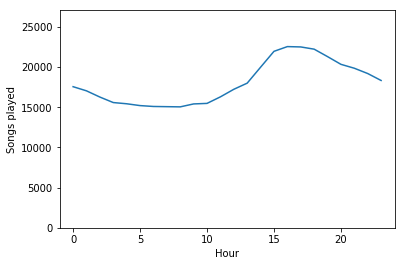

In [17]:
plt.plot(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop rows with missing values

In [18]:
data_valid = data.dropna(how = "any", subset = ["userId", "sessionId"])

In [19]:
data_valid.count()

543705

In [20]:
data.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



We see in the first row that are userID values that are empty strings.

In [21]:
data_valid = data_valid.filter(data_valid["userId"] != "")

In [22]:
data_valid.count()

528005

# Users Downgrade Their Accounts

In [23]:
data_valid.filter("Page = 'Submit Downgrade'")

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, hour: string]

In [24]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [25]:
data_downgrade = data_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [26]:
data_downgrade.show(2)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+----+----------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|hour|downgraded|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+----+----------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|   0|         0|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The

In [27]:
# Window function that let us focus on the partition we need. We use this to both downgraded and churn analysis

windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [28]:
data_ever_downgrade = data_downgrade.withColumn("ever_downgraded", Fsum("downgraded").over(windowval))

In [29]:
data_ever_downgrade.select(["userId", "firstname", "ts", "page", "level", "ever_downgraded"]).show(5)

+------+---------+-------------+--------------------+-----+---------------+
|userId|firstname|           ts|                page|level|ever_downgraded|
+------+---------+-------------+--------------------+-----+---------------+
|100010| Darianna|1539254318000|Cancellation Conf...| free|              0|
|100010| Darianna|1539254305000|              Cancel| free|              0|
|100010| Darianna|1539254304000|         Roll Advert| free|              0|
|100010| Darianna|1539254279000|            NextSong| free|              0|
|100010| Darianna|1539254097000|            NextSong| free|              0|
+------+---------+-------------+--------------------+-----+---------------+
only showing top 5 rows



# Define Churn

In [30]:
# Cancellation confirmation

cancel_conf = data_valid.filter("Page = 'Cancellation Confirmation'")

In [31]:
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [32]:
data_churn = data_valid.withColumn("churn", flag_cancel_event("page"))

In [33]:
data_ever_churn = data_churn.withColumn("ever_churn", Fsum("churn").over(windowval))

#### Let's create some useful columns to use later

In [34]:
# Create column 'time' to better read the time
time_parser = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
data_time = data_ever_churn.withColumn('time', time_parser('ts'))
data_time = data_time.withColumn('time_registration', time_parser('registration'))


In [35]:
data_to_analyse = data_time.select(["userId","gender", "time", "page", "level", "ever_churn"]) \
             .dropDuplicates(['userId']) \
             .sort(['userId'])

In [36]:
data_to_analyse.show(5)

+------+------+-------------------+--------------------+-----+----------+
|userId|gender|               time|                page|level|ever_churn|
+------+------+-------------------+--------------------+-----+----------+
|    10|     M|2018-10-09 03:22:44|Cancellation Conf...| paid|         1|
|   100|     M|2018-11-30 19:34:28|           Thumbs Up| paid|         0|
|100001|     F|2018-10-02 14:50:59|Cancellation Conf...| free|         1|
|100002|     F|2018-11-02 08:17:40|         Roll Advert| free|         0|
|100003|     F|2018-11-08 07:19:52|Cancellation Conf...| paid|         1|
+------+------+-------------------+--------------------+-----+----------+
only showing top 5 rows



# ------------------------------ Data Analysis --------------------------------------------

### Total proportion of users that cancel vs. those who don't give up

In [37]:
# First I'm going to calculate the total percentage of user that cancel in relation to users who no cancel
data_cancel_proportion = data_to_analyse.groupby(['ever_churn']).count().toPandas()

In [38]:
data_cancel_proportion

,ever_churn,count
0,0,349
1,1,99


In [39]:
data_cancel_proportion['percentage'] = data_cancel_proportion['count']/data_cancel_proportion['count'].sum()
data_cancel_proportion

,ever_churn,count,percentage
0,0,349,0.779018
1,1,99,0.220982


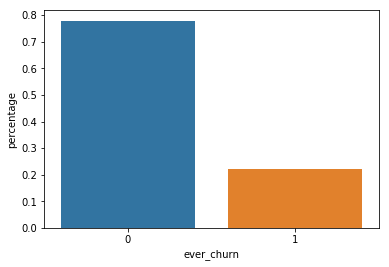

In [40]:
sns.barplot(x='ever_churn', y='percentage', data=data_cancel_proportion);

### Analysis by gender

In [41]:
data_by_gender = data_to_analyse.groupby(['gender', 'ever_churn']).count().toPandas()

In [42]:
data_by_gender

,gender,ever_churn,count
0,F,0,153
1,F,1,45
2,M,0,196
3,M,1,54


In [43]:
percentage = [153/349,45/99,196/349,54/99]
data_by_gender['percentage'] = percentage

In [44]:
data_by_gender

,gender,ever_churn,count,percentage
0,F,0,153,0.438395
1,F,1,45,0.454545
2,M,0,196,0.561605
3,M,1,54,0.545455


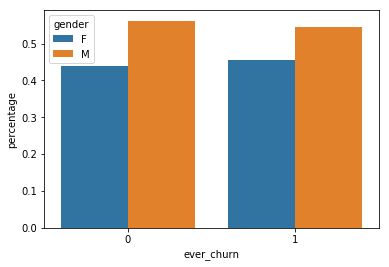

In [45]:
ax = sns.barplot(x='ever_churn', y='percentage', hue='gender', data=data_by_gender)

I don't observe the gender have influence in the churn rate

### Users churn analysis by level

In [46]:
data_level = data_to_analyse.groupby(['level', 'ever_churn']).count().toPandas()

In [47]:
data_level

,level,ever_churn,count
0,free,0,140
1,paid,0,209
2,free,1,32
3,paid,1,67


In [48]:
percentage2 = [140/349,209/349,32/99,67/99]
data_level['percentage'] = percentage2

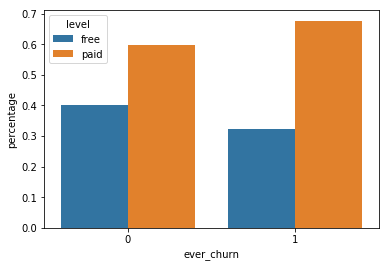

In [49]:
sns.barplot(x='ever_churn', y='percentage', hue='level', data=data_level);

it seems that the level influence when cancel the service because the paid level cancel more than the free level in relative terms

### Thumbs Up

In [50]:
data_thumbsUp = data_time.where('page=="Thumbs Up"').groupby(['ever_churn']).count().toPandas()

In [51]:
data_thumbsUp

,ever_churn,count
0,0,19526
1,1,4300


In [52]:
# We have to weigh the count with the percentage of total cancelations
data_thumbsUp['weighted count'] = data_thumbsUp['count']/data_cancel_proportion['percentage']

In [53]:
data_thumbsUp['weighted percentage'] = data_thumbsUp['weighted count'] / data_thumbsUp['weighted count'].sum()

In [54]:
data_thumbsUp

,ever_churn,count,weighted count,weighted percentage
0,0,19526,25064.893983,0.562959
1,1,4300,19458.585859,0.437041


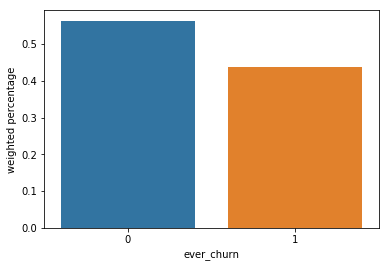

In [55]:
sns.barplot(x='ever_churn', y='weighted percentage', data=data_thumbsUp);

We can see that users who give up show less thumbs up. Let's do the same with thumbs down

### Thumbs Down

In [56]:
data_thumbsDown = data_time.where('page=="Thumbs Down"').groupby(['ever_churn']).count().toPandas()

In [57]:
# We have to weigh the count with the percentage of total cancelations
data_thumbsDown['weighted count'] = data_thumbsDown['count']/data_cancel_proportion['percentage']
data_thumbsDown['weighted percentage'] = data_thumbsDown['weighted count'] / data_thumbsDown['weighted count'].sum()

data_thumbsDown

,ever_churn,count,weighted count,weighted percentage
0,0,3755,4820.171920,0.479554
1,1,1156,5231.191919,0.520446


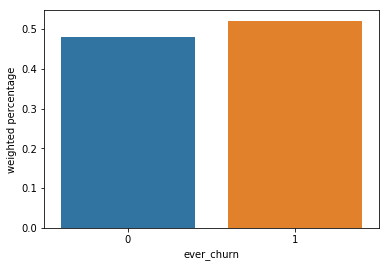

In [58]:
sns.barplot(x='ever_churn', y='weighted percentage', data=data_thumbsDown);

we observe a light larger thumbs down in users who give up

### Songs played

In [59]:
data_songs_played = data_time.where('page=="NextSong"').groupby(['userId','ever_churn']).count().toPandas()

In [60]:
data_songs_played = data_songs_played.sort_values('ever_churn')

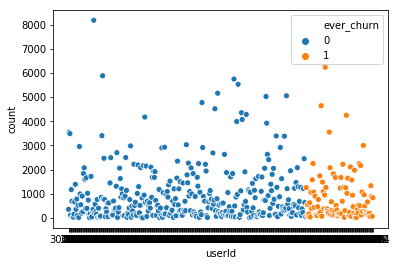

In [61]:
sns.scatterplot(x='userId', y='count', hue='ever_churn', data=data_songs_played);

### Songs played per session on average

In [62]:
songs_per_session = data_time.where('page == "NextSong"') \
                 .groupby(['ever_churn', 'userId', 'sessionId']).count()\
                 .groupby(['ever_churn', 'userId']).agg({'count':'avg'})\
                 .withColumnRenamed('avg(count)', 'songs_played_per_session(avg)')\
                 .toPandas()

In [63]:
songs_per_session = songs_per_session.sort_values('ever_churn')

In [64]:
songs_per_session

,ever_churn,userId,songs_played_per_session(avg)
447,0,300029,51.142857
387,0,12,154.260870
243,0,283,124.535714
242,0,193,14.125000
241,0,82,61.631579
240,0,241,62.909091
239,0,115,6.000000
238,0,176,8.750000
237,0,144,26.166667
386,0,62,94.571429


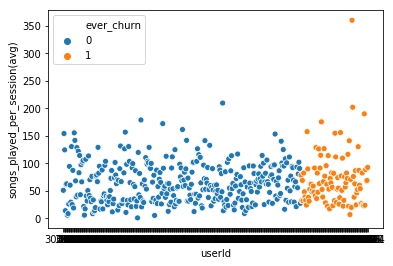

In [65]:
sns.scatterplot(x='userId', y='songs_played_per_session(avg)', hue='ever_churn', data=songs_per_session);

### Subscription time 

In [66]:
subscription_time = data_time \
    .select('userId','registration','ts','ever_churn') \
    .withColumn('subscription_time',(data_time.ts-data_time.registration)) \
    .groupBy('userId','ever_churn') \
    .agg({'subscription_time':'max'}) \
    .withColumnRenamed('max(subscription_time)','subscription_time') \
    .select('userId', 'ever_churn', (col('subscription_time')/1000/3600/24).alias('subscription_time')) \
    .toPandas()

In [67]:
subscription_time = subscription_time.sort_values('ever_churn')

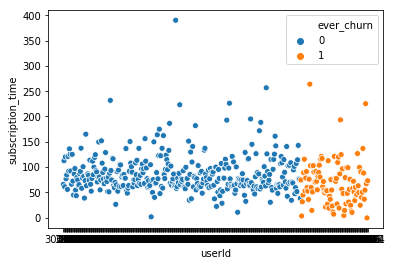

In [68]:
sns.scatterplot(x='userId', y='subscription_time', hue='ever_churn', data=subscription_time);

### Number of songs added to playlist

In [69]:
songs_added_playlist = data_time.where('page=="Add to Playlist"').groupby(['userId','ever_churn']).count().toPandas()

In [70]:
songs_added_playlist = songs_added_playlist.sort_values('ever_churn')

In [71]:
songs_added_playlist.head(3)

,userId,ever_churn,count
427,300029,0,13
368,62,0,20
232,283,0,108


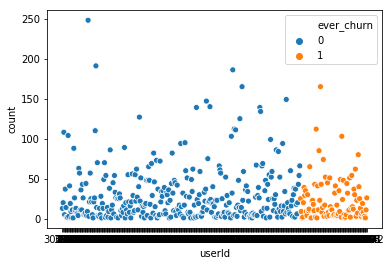

In [72]:
sns.scatterplot(x='userId', y='count', hue='ever_churn', data=songs_added_playlist);

Number of songs added to playlist seems to be a good feature to predict the churn label

### Add Friend page Analysis

In [73]:
added_friends = data_time.where('page=="Add Friend"').groupby(['userId','ever_churn']).count().toPandas()

In [74]:
added_friends.head(4)

,userId,ever_churn,count
0,100010,1,3
1,200002,1,2
2,296,1,2
3,125,0,3


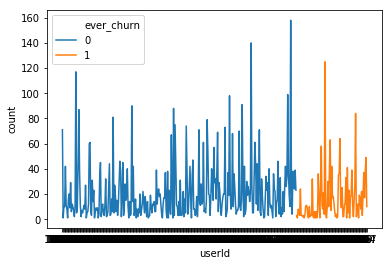

In [75]:
sns.lineplot(x='userId', y='count', hue='ever_churn', data=added_friends);

It seems there is a trend where users that don't give up add more friends

### Help page Analysis

In [76]:
help_page = data_time.where('page=="Help"').groupby(['userId','ever_churn']).count().toPandas()

In [77]:
help_page.head(3)

,userId,ever_churn,count
0,200002,1,1
1,296,1,2
2,125,0,2


In [78]:
help_page = help_page.sort_values('ever_churn')

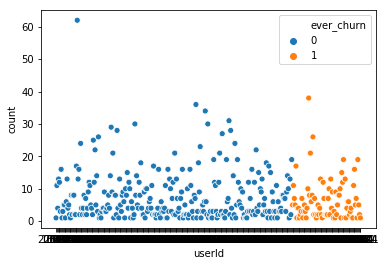

In [79]:
sns.scatterplot(x='userId', y='count', hue='ever_churn', data=help_page);

### Roll Advert page Analysis

In [80]:
roll_advert_page = data_time.where('page=="Roll Advert"').groupby(['userId','ever_churn']).count().toPandas()

In [81]:
roll_advert_page.head(4)

,userId,ever_churn,count
0,100010,1,22
1,200002,1,11
2,296,1,9
3,125,0,6


In [82]:
roll_advert_page = roll_advert_page.sort_values('ever_churn')

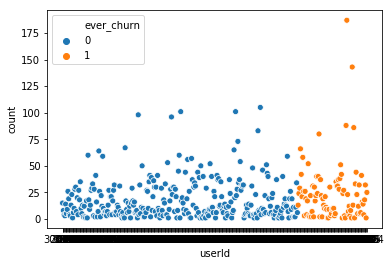

In [83]:
sns.scatterplot(x='userId', y='count', hue='ever_churn', data=roll_advert_page);

### Upgrade page Analysis

In [84]:
upgrade_page = data_time.where('page=="Upgrade"').groupby(['userId','ever_churn']).count().toPandas()

In [85]:
upgrade_page = upgrade_page.sort_values('ever_churn')

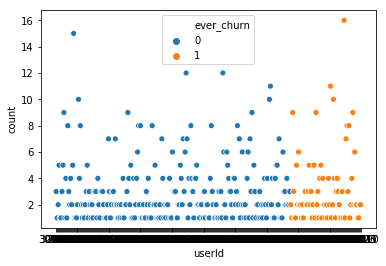

In [86]:
sns.scatterplot(x='userId', y='count', hue='ever_churn', data=upgrade_page);

# --------------------    Feature Engineering       ----------------------------------------

According to the Data Analysis I'm going to select the below features

### Feature 1: Level

In [87]:
feature_level = data_time.select('userId', 'level').dropDuplicates() \
                .replace(['free','paid'], ['0','1'], 'level') \
                .select('userId', col('level').cast('int'))

In [88]:
feature_level.show(3)

+------+-----+
|userId|level|
+------+-----+
|    94|    1|
|100021|    0|
|100029|    0|
+------+-----+
only showing top 3 rows



### Feature 2: Number of thumbs up

In [89]:
feature_thumbs_up = data_time.select('userId','page') \
                   .where(data_time.page == 'Thumbs Up') \
                   .groupBy('userID') \
                   .count() \
                   .withColumnRenamed('count', 'thumbs_up') 

In [90]:
feature_thumbs_up.show(3)

+------+---------+
|userID|thumbs_up|
+------+---------+
|   296|        8|
|100010|        4|
|200002|       15|
+------+---------+
only showing top 3 rows



### Feature 3: Number of thumbs down

In [91]:
feature_thumbs_down = data_time.select('userId','page') \
                     .where(data_time.page == 'Thumbs Down') \
                     .groupby('userId') \
                     .count() \
                     .withColumnRenamed('count', 'thumbs_down') 

### Feature 4: Songs played per session

In [92]:
feature_songs =  data_time.where('page == "NextSong"') \
                 .groupby('userId', 'sessionId').count()\
                 .groupby('userId').agg({'count':'avg'})\
                 .withColumnRenamed('avg(count)', 'songs_session')

feature_songs.show(3)

+------+-------------+
|userId|songs_session|
+------+-------------+
|200002|         62.0|
|   296|         22.4|
|100010|         48.0|
+------+-------------+
only showing top 3 rows



### Feature 5: Subscription time

In [93]:
feature_subscription_time = data_time \
    .select('userId','registration','ts') \
    .withColumn('subscription_time',(data_time.ts-data_time.registration)) \
    .groupBy('userId') \
    .agg({'subscription_time':'max'}) \
    .withColumnRenamed('max(subscription_time)','subscription_time') \
    .select('userId',(col('subscription_time')/1000/3600/24).alias('subscription_time'))

feature_subscription_time.show(3)

+------+------------------+
|userId| subscription_time|
+------+------------------+
|100010|14.328449074074074|
|200002| 53.32314814814814|
|   296| 26.63826388888889|
+------+------------------+
only showing top 3 rows



### Feature 6: Number of songs added to playlist

In [94]:
feature_added_playlist = data_time.where('page=="Add to Playlist"').groupby('userId').count() \
                         .withColumnRenamed('count','added_playlist')

feature_added_playlist.show(3)

+------+--------------+
|userId|added_playlist|
+------+--------------+
|100010|             1|
|200002|             6|
|   296|             3|
+------+--------------+
only showing top 3 rows



### Feature 7: Number of Add Friends events

In [95]:
feature_added_friends = data_time.where('page=="Add Friend"').groupby('userId').count() \
                        .withColumnRenamed('count', 'added_friends')
feature_added_friends.show(3)

+------+-------------+
|userId|added_friends|
+------+-------------+
|100010|            3|
|200002|            2|
|   296|            2|
+------+-------------+
only showing top 3 rows



### Feature 8: Number of Help page events

In [96]:
feature_help = data_time.where('page=="Help"') \
              .groupby('userId').count() \
              .withColumnRenamed('count','help')
feature_help.show(3)

+------+----+
|userId|help|
+------+----+
|   296|   2|
|200002|   1|
|   125|   2|
+------+----+
only showing top 3 rows



### Feature 9: Roll Advert page analysis

In [97]:
feature_advert = data_time.where('page=="Roll Advert"') \
              .groupby('userId').count() \
              .withColumnRenamed('count','advert')
feature_advert.show(3)

+------+------+
|userId|advert|
+------+------+
|100010|    22|
|200002|    11|
|   296|     9|
+------+------+
only showing top 3 rows



### Include in the data the column label

In [98]:
label = data_time.select('userId', col('ever_churn').alias('label')) \
       .dropDuplicates()
label.show(3)

+------+-----+
|userId|label|
+------+-----+
|100010|    1|
|200002|    1|
|   296|    1|
+------+-----+
only showing top 3 rows



### Finally we join all the features with the label, drop userId and fill na with 0

In [99]:
data = feature_level.join(feature_thumbs_up, 'userId', 'outer') \
                    .join(feature_thumbs_down, 'userId', 'outer') \
                    .join(feature_songs,'userId', 'outer') \
                    .join(feature_subscription_time,'userId', 'outer') \
                    .join(feature_added_playlist,'userId', 'outer')  \
                    .join(feature_added_friends,'userId', 'outer') \
                    .join(feature_help,'userId', 'outer') \
                    .join(feature_advert,'userId', 'outer') \
                    .join(label,'userId', 'outer') \
                    .drop('userId')  \
                    .fillna(0)

In [100]:
data.show()

+-----+---------+-----------+------------------+------------------+--------------+-------------+----+------+-----+
|level|thumbs_up|thumbs_down|     songs_session| subscription_time|added_playlist|added_friends|help|advert|label|
+-----+---------+-----------+------------------+------------------+--------------+-------------+----+------+-----+
|    0|        4|          3|              48.0|14.328449074074074|             1|            3|   0|    22|    1|
|    1|       15|          5|              62.0| 53.32314814814814|             6|            2|   1|    11|    1|
|    0|       15|          5|              62.0| 53.32314814814814|             6|            2|   1|    11|    1|
|    1|        8|          0|              22.4| 26.63826388888889|             3|            2|   2|     9|    1|
|    0|        8|          0|              22.4| 26.63826388888889|             3|            2|   2|     9|    1|
|    0|        3|          1|20.666666666666668|105.42211805555554|             

In [101]:
data.columns[:-1]

['level',
 'thumbs_up',
 'thumbs_down',
 'songs_session',
 'subscription_time',
 'added_playlist',
 'added_friends',
 'help',
 'advert']

# Modeling

Source: http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.classification

In [102]:
# Vector Assembler
assembler = VectorAssembler(inputCols= data.columns[:-1], outputCol='features')
features_vector = assembler.transform(data)

In [103]:
# Data Standarization:
scaler = StandardScaler(inputCol='features', outputCol='features_scaled', withStd=True)
scaler_fit = scaler.fit(features_vector)
scaled_data = scaler_fit.transform(features_vector)

In [104]:
# train, test and validation data split
train_data, rest = scaled_data.randomSplit([0.8, 0.2], seed=42)                                
validation_data, test_data = rest.randomSplit([0.5, 0.5], seed=42)

### Model 1: Logistic Regression

In [105]:
# instantiate a LogisticRegression object
lr = LogisticRegression(labelCol='label', featuresCol='features_scaled')
# Fitting the model to the train_data
lr_model = lr.fit(train_data)
# Prediction
lr_prediction = lr_model.transform(validation_data)

In [106]:
lr_prediction.select('label', 'features_scaled', 'rawPrediction', 'probability', 'prediction').show(3)

+-----+--------------------+--------------------+--------------------+----------+
|label|     features_scaled|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|[2.00359616069337...|[0.77491390034122...|[0.68458290919279...|       0.0|
|    1|[2.00359616069337...|[1.37047444638144...|[0.79745679670439...|       0.0|
|    0|[2.00359616069337...|[0.76124294521869...|[0.68162352979850...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



In [107]:
# Set the evaluator to F1 score and Accuracy. We will use this in all the below models
f1_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

In [108]:
lr_f1 = f1_evaluator.evaluate(lr_prediction)
lr_accuracy = accuracy_evaluator.evaluate(lr_prediction)

In [109]:
print('____________________________')
print('Model 1: Logistic Regression')
print('____________________________')
print('F1 score: {}'.format(lr_f1))
print('____________________________')
print('Accuracy: {}'.format(lr_accuracy))
print('____________________________')

____________________________
Model 1: Logistic Regression
____________________________
F1 score: 0.6828312218383141
____________________________
Accuracy: 0.7659574468085106
____________________________


### Model 2: Decision Tree Classifier

In [110]:
# instantiate a DecisionTreeClassifier object
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features_scaled')
# Fitting the model to the train_data
dt_model = dt.fit(train_data)
# Prediction
dt_prediction = dt_model.transform(validation_data)

In [111]:
dt_f1 = f1_evaluator.evaluate(dt_prediction)
dt_accuracy = accuracy_evaluator.evaluate(dt_prediction)

In [114]:
print('________________________________')
print('Model 2: Desion Tree Classifier')
print('________________________________')
print('F1 score: {}'.format(dt_f1))
print('________________________________')
print('Accuracy: {}'.format(dt_accuracy))
print('________________________________')

________________________________
Model 2: Desion Tree Classifier
________________________________
F1 score: 0.8173663024726855
________________________________
Accuracy: 0.8297872340425532
________________________________


### Model 3: LinearSVC

In [115]:
# instantiate a LinearSVC object
SVC = LinearSVC(labelCol='label', featuresCol='features_scaled')
# Fitting the model to the train_data
SVC_model = SVC.fit(train_data)
# Prediction
SVC_prediction = SVC_model.transform(validation_data)

In [116]:
SVC_f1 = f1_evaluator.evaluate(SVC_prediction)
SVC_accuracy = accuracy_evaluator.evaluate(SVC_prediction)

In [119]:
print('________________________________')
print('Model 3: LinearSVC')
print('________________________________')
print('F1 score: {}'.format(SVC_f1))
print('________________________________')
print('Accuracy: {}'.format(SVC_accuracy))
print('________________________________')

________________________________
Model 3: LinearSVC
________________________________
F1 score: 0.6357031655422937
________________________________
Accuracy: 0.7446808510638298
________________________________


Note: LinearSVC model takes a long long time to train and evaluate so I discard this model

### Model 4: Gradient-Boosted Trees (GBTClassifier)

In [120]:
# instantiate a GBTClassifier object
GBT = GBTClassifier(labelCol='label', featuresCol='features_scaled')
# Fitting the model to the train_data
GBT_model = GBT.fit(train_data)
# Prediction
GBT_prediction = GBT_model.transform(validation_data)

In [121]:
GBT_f1 = f1_evaluator.evaluate(GBT_prediction)
GBT_accuracy = accuracy_evaluator.evaluate(GBT_prediction)

In [122]:
print('________________________________')
print('Model 4: Gradient-Boosted Trees')
print('________________________________')
print('F1 score: {}'.format(GBT_f1))
print('________________________________')
print('Accuracy: {}'.format(GBT_accuracy))
print('________________________________')

________________________________
Model 4: Gradient-Boosted Trees
________________________________
F1 score: 0.9086831512363429
________________________________
Accuracy: 0.9148936170212766
________________________________


### Model 5: RandomForestClassifier

In [123]:
# instantiate a RandomForestClassifier object
Ramdom_Forest = RandomForestClassifier(labelCol='label', featuresCol='features_scaled')
# Fitting the model to the train_data
Ramdom_Forest_model = Ramdom_Forest.fit(train_data)
# Prediction
Ramdom_Forest_prediction = Ramdom_Forest_model.transform(validation_data)

In [124]:
Ramdom_Forest_f1 = f1_evaluator.evaluate(Ramdom_Forest_prediction)
Ramdom_Forest_accuracy = accuracy_evaluator.evaluate(Ramdom_Forest_prediction)

In [125]:
print('________________________________')
print('Model 5: Random Forest Classifier')
print('________________________________')
print('F1 score: {}'.format(Ramdom_Forest_f1))
print('________________________________')
print('Accuracy: {}'.format(Ramdom_Forest_accuracy))
print('________________________________')

________________________________
Model 5: Random Forest Classifier
________________________________
F1 score: 0.8271703265445443
________________________________
Accuracy: 0.851063829787234
________________________________


### The best model is number 4: Gradient-Boosted Trees (GBTClassifier), with a F1 score of 0.90 and an Accuracy of  0.91
Let's analyse this model more in depth 

In [138]:
# First let's extract the params of the model
GBT_model.extractParamMap()

{Param(parent='GBTClassifier_46648013257f49f44db7', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_46648013257f49f44db7', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_46648013257f49f44db7', name='featuresCol', doc='features column name'): 'features_scaled',
 Param(parent='GBTClassifier_46648013257f49f44db7', name='labelCol', doc='label column name'): 'label',
 Param(parent='GBTClassifier_46648013257f49f44db7', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic'): 'logistic',


### Feature Importance Analysis

In [139]:
feature_importances = GBT_model.featureImportances.values

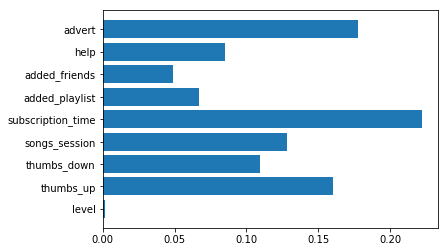

In [146]:

y = np.arange(len(data.columns[:-1]))
plt.barh(y, feature_importances, align='center')
plt.yticks(y, data.columns[:-1]);


# Conclusion
After have explored the data, cleaned, defined churn, done data analysis that help us with the feature angineering, have created the feature vector and apply the standard scaler, then we have train 5 machine learning models to check what could be the best.
Based on the F1-score and on the accuracy, the best model is number 4: Gradient-Boosted Trees (GBTClassifier), with a F1 score of 0.90 and an Accuracy of 0.91
Finally we have extracted the params of the model and have done a Feature Importance Analysis where we have found that the most important feature that let us to forecast if a user will give up the streaming music service is the subscription time, followed by: the number of roll adverts watched, the number of thumbs ups and the number of songs listened by session among other features 